**The Baseline code with attention**

In [1]:
!pip install d2l==1.0.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.7 MB/s eta 0:00:00


In [2]:
!pip install matplotlib
%matplotlib inline
!pip install matplotlib-inline
import sys
!{sys.executable} -m pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import collections
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch.optim as optim

In [5]:
class AttentionDecoder(d2l.Decoder):  
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError

In [6]:
class AdditiveAttention(nn.Module): 
    def __init__(self, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.LazyLinear(num_hiddens, bias=False)
        self.W_q = nn.LazyLinear(num_hiddens, bias=False)
        self.w_v = nn.LazyLinear(1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)

        return torch.bmm(self.dropout(self.attention_weights), values)

In [7]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
            
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [9]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],lr=0.005)

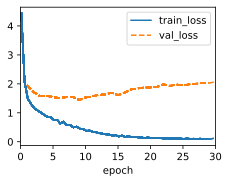

In [10]:
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [12]:
model

Seq2Seq(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(194, 256)
    (rnn): GRU(
      (rnn): GRU(256, 256, num_layers=2, dropout=0.2)
    )
  )
  (decoder): Seq2SeqAttentionDecoder(
    (attention): AdditiveAttention(
      (W_k): Linear(in_features=256, out_features=256, bias=False)
      (W_q): Linear(in_features=256, out_features=256, bias=False)
      (w_v): Linear(in_features=256, out_features=1, bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (embedding): Embedding(214, 256)
    (rnn): GRU(512, 256, num_layers=2, dropout=0.2)
    (dense): Linear(in_features=256, out_features=214, bias=True)
  )
)

In [13]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


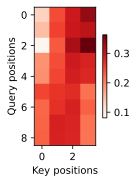

In [14]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

**Adjusting the model with 1 hidden layer**

In [15]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 1, 0.2
encoder = d2l.Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],lr=0.005)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.9/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


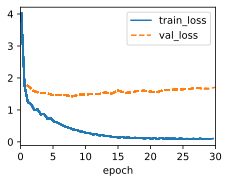

In [16]:
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [17]:
model

Seq2Seq(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(194, 256)
    (rnn): GRU(
      (rnn): GRU(256, 256, dropout=0.2)
    )
  )
  (decoder): Seq2SeqAttentionDecoder(
    (attention): AdditiveAttention(
      (W_k): Linear(in_features=256, out_features=256, bias=False)
      (W_q): Linear(in_features=256, out_features=256, bias=False)
      (w_v): Linear(in_features=256, out_features=1, bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (embedding): Embedding(214, 256)
    (rnn): GRU(512, 256, dropout=0.2)
    (dense): Linear(in_features=256, out_features=214, bias=True)
  )
)

In [18]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['je', "l'ai", 'emporté', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


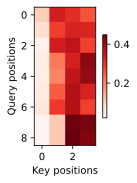

In [19]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

**Adjusting the model with 3 hidden layers**

In [20]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 3, 0.2
encoder = d2l.Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],lr=0.005)

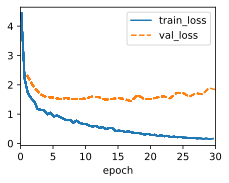

In [21]:
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [22]:
model

Seq2Seq(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(194, 256)
    (rnn): GRU(
      (rnn): GRU(256, 256, num_layers=3, dropout=0.2)
    )
  )
  (decoder): Seq2SeqAttentionDecoder(
    (attention): AdditiveAttention(
      (W_k): Linear(in_features=256, out_features=256, bias=False)
      (W_q): Linear(in_features=256, out_features=256, bias=False)
      (w_v): Linear(in_features=256, out_features=1, bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (embedding): Embedding(214, 256)
    (rnn): GRU(512, 256, num_layers=3, dropout=0.2)
    (dense): Linear(in_features=256, out_features=214, bias=True)
  )
)

In [23]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'mouillé', '.'], bleu,0.658
i'm home . => ['je', 'me', 'porte', 'bien', '.'], bleu,0.000


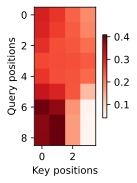

In [24]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

**Adjusting the model with 4 hidden layers**

In [25]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 4, 0.2
encoder = d2l.Seq2SeqEncoder(len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],lr=0.005)

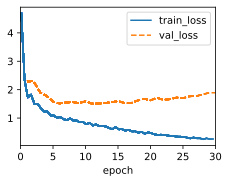

In [26]:
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [27]:
model

Seq2Seq(
  (encoder): Seq2SeqEncoder(
    (embedding): Embedding(194, 256)
    (rnn): GRU(
      (rnn): GRU(256, 256, num_layers=4, dropout=0.2)
    )
  )
  (decoder): Seq2SeqAttentionDecoder(
    (attention): AdditiveAttention(
      (W_k): Linear(in_features=256, out_features=256, bias=False)
      (W_q): Linear(in_features=256, out_features=256, bias=False)
      (w_v): Linear(in_features=256, out_features=1, bias=False)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (embedding): Embedding(214, 256)
    (rnn): GRU(512, 256, num_layers=4, dropout=0.2)
    (dense): Linear(in_features=256, out_features=214, bias=True)
  )
)

In [28]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ['j’ai', 'fait', '.'], bleu,0.000
he's calm . => ['je', "c'est", '<unk>', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'malade', '.'], bleu,0.512


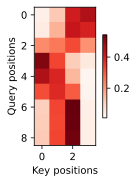

In [29]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')